In [77]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from keras.utils import to_categorical

import sys

import numpy as np

class GAN():
    
    def init_v17_v10_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V10'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
            
    def init_v17_v14_plot(self):
        self.fig, self.axes = plt.subplots(nrows=6, ncols=2, figsize=(14,18))
        self.col1, self.col2 = 'V17', 'V14'
        self.plot_counter = 0

        for i in range(6):

            self.data_fraud.plot(kind='scatter', ax=self.axes[i,0], x = self.col1, y = self.col2)

            self.axes[i, 0].set_title('Actual Fraud') 
        
    def load_fraud_data(self):
        # Read in dataset from csv file
        data = pd.read_csv("creditcard.csv")
        
        # Take only the fraud examples
        data_fraud = data.loc[data['Class'] == 1]
        
        # Remove class column as not needed, these are all Class=1
        data_fraud = data_fraud.loc[:, data_fraud.columns != 'Class']
        self.data_cols = data_fraud.columns
        
        # Scale data using StandardScaler
        pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(data_fraud)
        data_fraud = preprocessor.transform(data_fraud)
        data_fraud = pd.DataFrame(data_fraud, columns=self.data_cols)
        
        self.data_fraud = data_fraud
        
    def load_raw_data(self):
        return pd.read_csv("creditcard.csv")
        
    def __init__(self):
        self.img_rows = 1 
        self.img_cols = 30
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.00002, 0.5)
        
        # Load fraud data 
        self.load_fraud_data()
        self.data_raw = self.load_raw_data()
        
        # Initialise the data plot grid
#         self.init_v17_v10_plot()
        self.init_v17_v10_plot()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy','categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=['binary_crossentropy'], optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)
    

    
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape))) # , activation='tanh'
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dense(2, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)
        

        valid = Dense(1, activation="sigmoid")(validity)
        label = Dense(2, activation="softmax")(validity)

        return Model(img, [valid, label])
#         return Model(img, label)
    
    def generate_train_test_sample(self, data, test_ratio=0.3): 
        
        # Assign variables x and y corresponding to row data and it's class value
        X = data.ix[:, data.columns != 'Class']
        y = data.ix[:, data.columns == 'Class']

        # performs random split (i.e random selects 70% datapoints)
        X_train, X_test, y_train, y_test = train_test_split(X,y)
        
        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)

        return X_train_prp, X_test_prp, y_train, y_test
    
    def generate_train_test_timeseries(data, test_ratio=0.3):

        total_samples = data.shape[0]

        cutoff = int(total_samples * (1 - test_ratio))

        data.sort_values('Time', inplace=True)

        X_train = data.loc[0:cutoff, data.columns != 'Class']
        y_train = data.loc[0:cutoff, data.columns == 'Class']
        X_test = data.loc[cutoff:, data.columns != 'Class']
        y_test = data.loc[cutoff:, data.columns == 'Class']

        pipeline = Pipeline([
            ('scaling', StandardScaler()),
        ])
        preprocessor = pipeline.fit(X_train)
        X_train_prp = preprocessor.transform(X_train)

        X_test_prp = preprocessor.transform(X_test)



        return X_train_prp, y_train, X_test_prp, y_test
    

    def train(self, epochs, batch_size=128, save_interval=200):
        
        data_cols = self.data_cols
        # Load the dataset
        X_train = self.data_fraud.values
        
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(self.data_raw)
        
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)
        y_train = np.expand_dims(y_train, axis=1)

        half_batch = int(batch_size / 2)
        self.losses = []
        
        cw1 = {0: 1, 1: 1}
        cw2 = {i: 2 / half_batch for i in range(2)}
        cw2[2] = 1 / half_batch
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            imgs_ys = y_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)
            
            self.discriminator.trainable = True
            # Train the discriminator
#             X = np.concatenate((imgs,gen_imgs))
#             y = np.zeros([len(imgs)+len(gen_imgs),3])
#             y[0:len(imgs),2] = [i[0][0] for i in imgs_ys]
#             y[0:len(imgs),1] = 1
#             y[len(imgs):,0] = 1
            
            valid = np.ones((half_batch, 1))
            fake = np.zeros((half_batch, 1))
            
            labels = np.full((2*half_batch,3),0)
            labels = to_categorical(imgs_ys, num_classes=2)
        
            fake_labels = to_categorical(np.full((half_batch, 1), 1), num_classes=2)
            
#             d_loss = self.discriminator.train_on_batch(X, y)
#             d_loss = [0.5 * (i+j) for i,j in (d_loss_real, d_loss_fake)]
#             d_loss = 0.5*(d_loss_real[0]+d_loss_fake[0])
#             d_acc = 0.5*(d_loss_real[1]+d_loss_fake[1])

            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
#             valid_y = np.array([1] * batch_size)
#             valid_y = np.zeros([batch_size,2])
#             valid_y[:,1] = 1

            valid_y = np.ones((batch_size, 1))
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y, class_weight=[cw1, cw2])
            
            self.losses.append((d_loss, g_loss))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, imgs, gen_imgs)
                
        self.save_loss_plot()
        
    def save_loss_plot(self):
        losses = np.array(self.losses)

        fig, ax = plt.subplots()
        plt.plot([i[0][0] for i in losses], label='Discriminator')
        plt.plot([i[1] for i in losses], label='Generator')
        plt.title("Training Losses")
        plt.legend()
        
        fig.savefig("GANv1-ssl-losses.png")
        plt.close()
        
    def save_imgs(self, epoch, img, gen_imgs):

        col1, col2 = 'V17', 'V10'
        noise = np.random.normal(0, 1, (492, 100))

            # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[2])
        gen_samples = pd.DataFrame(gen_imgs, columns=self.data_cols)
        
        gen_samples.plot(kind='scatter', ax=self.axes[self.plot_counter,1], x = col1, y = col2)
        self.plot_counter = self.plot_counter +1
        
        if self.plot_counter == 6:
            self.fig.tight_layout()
            self.fig.savefig("GANv1-ssl-v17-v10-img_2.png")
            plt.close()
            
    
    def test_as_classifier(self):
        from sklearn.metrics import confusion_matrix, classification_report
        
        data_raw = pd.read_csv("creditcard.csv")
    
        X_train, X_test, y_train, y_test = self.generate_train_test_sample(data_raw)
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=1)
        y_train = np.expand_dims(y_train, axis=1)
#         y_test = np.expand_dims(y_test, axis=1)
        X_test = np.expand_dims(X_test, axis=3)
        X_test = np.expand_dims(X_test, axis=1)
        
        output = self.discriminator.predict(X_test)

        cutt_off_tr = 0.5
#         return y_pred
        y_pred = output[1]
        print(y_pred)
#         print(max(y_pred[:,0]),max(y_pred[:,1]),max(y_pred[:,2]))
#         fraud_indexes = y_test.values[np.where(y_test.values[:]=1]
        indices = [i for i, x in enumerate(y_test.values) if x == 1]
        y_score = np.full((y_pred.shape[0],1),0)
        y_score[np.where(y_pred[:,1]>=cutt_off_tr)] = 1
        y_score[np.where(y_pred[:,1]<cutt_off_tr)]  = 0
        print(y_score)
        print(y_test)
        print(1 in y_test.values)
        print(y_pred[indices])
        prfs = precision_recall_fscore_support(y_test, y_score, labels=[1])
        prfs0 = precision_recall_fscore_support(y_test, y_score, labels=[0])
        
        print(prfs)
        print(prfs0)
        
        print(classification_report(
        y_test,
        y_score,
        target_names = ["Genuine", "Fraud"],
        digits = 5))
        
        print (confusion_matrix(
        y_test,
        y_score))
        
        from sklearn.metrics import roc_curve, auc, roc_auc_score

        # short way
        print(roc_auc_score(y_test, y_score))
        return output



    

In [79]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=32, save_interval=1000)
    gan.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 30)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:219: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.395931, acc.: 69.88%] [G loss: 0.794164]
1 [D loss: 0.396174, acc.: 69.87%] [G loss: 0.759716]
2 [D loss: 0.382408, acc.: 67.77%] [G loss: 0.759628]
3 [D loss: 0.393578, acc.: 69.81%] [G loss: 0.745894]
4 [D loss: 0.377973, acc.: 66.71%] [G loss: 0.745222]
5 [D loss: 0.392032, acc.: 69.94%] [G loss: 0.726639]
6 [D loss: 0.374029, acc.: 66.63%] [G loss: 0.711615]
7 [D loss: 0.402126, acc.: 71.95%] [G loss: 0.718985]
8 [D loss: 0.393157, acc.: 70.23%] [G loss: 0.706728]
9 [D loss: 0.398901, acc.: 71.45%] [G loss: 0.719396]
10 [D loss: 0.393998, acc.: 69.41%] [G loss: 0.716293]
11 [D loss: 0.376748, acc.: 66.61%] [G loss: 0.726584]
12 [D loss: 0.398322, acc.: 70.28%] [G loss: 0.704438]
13 [D loss: 0.394408, acc.: 69.50%] [G loss: 0.700171]
14 [D loss: 0.391639, acc.: 69.15%] [G loss: 0.714304]
15 [D loss: 0.400009, acc.: 71.07%] [G loss: 0.719797]
16 [D loss: 0.399199, acc.: 71.14%] [G loss: 0.698634]
17 [D loss: 0.386350, acc.: 69.25%] [G loss: 0.713390]
18 [D loss: 0.373981

149 [D loss: 0.399306, acc.: 71.04%] [G loss: 0.907572]
150 [D loss: 0.409724, acc.: 73.41%] [G loss: 0.901464]
151 [D loss: 0.397709, acc.: 71.12%] [G loss: 0.900666]
152 [D loss: 0.392060, acc.: 70.23%] [G loss: 0.897493]
153 [D loss: 0.395067, acc.: 70.28%] [G loss: 0.898735]
154 [D loss: 0.387051, acc.: 69.90%] [G loss: 0.916330]
155 [D loss: 0.386939, acc.: 68.57%] [G loss: 0.902550]
156 [D loss: 0.421023, acc.: 75.60%] [G loss: 0.908001]
157 [D loss: 0.376116, acc.: 67.20%] [G loss: 0.916197]
158 [D loss: 0.397381, acc.: 70.99%] [G loss: 0.901314]
159 [D loss: 0.402477, acc.: 72.36%] [G loss: 0.901399]
160 [D loss: 0.421516, acc.: 75.40%] [G loss: 0.905868]
161 [D loss: 0.372537, acc.: 66.74%] [G loss: 0.917980]
162 [D loss: 0.388813, acc.: 69.76%] [G loss: 0.922477]
163 [D loss: 0.448942, acc.: 80.26%] [G loss: 0.908858]
164 [D loss: 0.392429, acc.: 69.74%] [G loss: 0.908177]
165 [D loss: 0.379865, acc.: 67.93%] [G loss: 0.893174]
166 [D loss: 0.432752, acc.: 77.88%] [G loss: 0.

298 [D loss: 0.408441, acc.: 73.12%] [G loss: 0.855455]
299 [D loss: 0.385437, acc.: 68.86%] [G loss: 0.859336]
300 [D loss: 0.379292, acc.: 67.88%] [G loss: 0.843093]
301 [D loss: 0.420066, acc.: 74.06%] [G loss: 0.838596]
302 [D loss: 0.388274, acc.: 69.08%] [G loss: 0.851650]
303 [D loss: 0.379739, acc.: 67.74%] [G loss: 0.854238]
304 [D loss: 0.387757, acc.: 69.56%] [G loss: 0.839769]
305 [D loss: 0.386649, acc.: 69.15%] [G loss: 0.843182]
306 [D loss: 0.421217, acc.: 75.06%] [G loss: 0.851869]
307 [D loss: 0.391430, acc.: 69.99%] [G loss: 0.840350]
308 [D loss: 0.384853, acc.: 68.65%] [G loss: 0.840025]
309 [D loss: 0.389771, acc.: 69.33%] [G loss: 0.844831]
310 [D loss: 0.381287, acc.: 68.01%] [G loss: 0.839572]
311 [D loss: 0.387252, acc.: 69.32%] [G loss: 0.846198]
312 [D loss: 0.402296, acc.: 72.15%] [G loss: 0.852502]
313 [D loss: 0.387128, acc.: 68.78%] [G loss: 0.853305]
314 [D loss: 0.381980, acc.: 67.87%] [G loss: 0.851073]
315 [D loss: 0.382124, acc.: 68.15%] [G loss: 0.

448 [D loss: 0.391163, acc.: 70.13%] [G loss: 0.806823]
449 [D loss: 0.386490, acc.: 68.67%] [G loss: 0.814810]
450 [D loss: 0.384322, acc.: 68.53%] [G loss: 0.802541]
451 [D loss: 0.398635, acc.: 71.20%] [G loss: 0.811141]
452 [D loss: 0.384242, acc.: 68.52%] [G loss: 0.809707]
453 [D loss: 0.381680, acc.: 68.02%] [G loss: 0.806044]
454 [D loss: 0.387283, acc.: 68.84%] [G loss: 0.801647]
455 [D loss: 0.382429, acc.: 68.24%] [G loss: 0.811403]
456 [D loss: 0.387980, acc.: 69.29%] [G loss: 0.807583]
457 [D loss: 0.399046, acc.: 71.35%] [G loss: 0.802251]
458 [D loss: 0.396825, acc.: 70.32%] [G loss: 0.803179]
459 [D loss: 0.397273, acc.: 71.20%] [G loss: 0.792894]
460 [D loss: 0.380894, acc.: 67.95%] [G loss: 0.805459]
461 [D loss: 0.389151, acc.: 70.00%] [G loss: 0.802943]
462 [D loss: 0.381611, acc.: 67.89%] [G loss: 0.799434]
463 [D loss: 0.379665, acc.: 67.80%] [G loss: 0.798753]
464 [D loss: 0.384696, acc.: 68.20%] [G loss: 0.802543]
465 [D loss: 0.385906, acc.: 68.32%] [G loss: 0.

595 [D loss: 0.376563, acc.: 66.86%] [G loss: 0.756589]
596 [D loss: 0.380115, acc.: 67.86%] [G loss: 0.780232]
597 [D loss: 0.388744, acc.: 68.91%] [G loss: 0.769158]
598 [D loss: 0.390732, acc.: 69.69%] [G loss: 0.765167]
599 [D loss: 0.382612, acc.: 67.83%] [G loss: 0.763515]
600 [D loss: 0.385511, acc.: 68.55%] [G loss: 0.772629]
601 [D loss: 0.376743, acc.: 67.17%] [G loss: 0.771768]
602 [D loss: 0.377053, acc.: 67.09%] [G loss: 0.765812]
603 [D loss: 0.382499, acc.: 67.75%] [G loss: 0.760394]
604 [D loss: 0.385567, acc.: 68.96%] [G loss: 0.763467]
605 [D loss: 0.392397, acc.: 69.80%] [G loss: 0.770924]
606 [D loss: 0.382248, acc.: 67.99%] [G loss: 0.755430]
607 [D loss: 0.380976, acc.: 67.63%] [G loss: 0.749132]
608 [D loss: 0.390967, acc.: 69.57%] [G loss: 0.764148]
609 [D loss: 0.381121, acc.: 67.66%] [G loss: 0.767810]
610 [D loss: 0.377542, acc.: 67.08%] [G loss: 0.768894]
611 [D loss: 0.393008, acc.: 70.05%] [G loss: 0.771589]
612 [D loss: 0.370832, acc.: 66.11%] [G loss: 0.

745 [D loss: 0.381810, acc.: 68.02%] [G loss: 0.746810]
746 [D loss: 0.392434, acc.: 70.01%] [G loss: 0.748055]
747 [D loss: 0.388727, acc.: 69.31%] [G loss: 0.750867]
748 [D loss: 0.387683, acc.: 68.79%] [G loss: 0.749110]
749 [D loss: 0.407395, acc.: 72.06%] [G loss: 0.745036]
750 [D loss: 0.391311, acc.: 69.11%] [G loss: 0.746440]
751 [D loss: 0.388676, acc.: 69.18%] [G loss: 0.742244]
752 [D loss: 0.384986, acc.: 68.40%] [G loss: 0.750646]
753 [D loss: 0.379486, acc.: 67.44%] [G loss: 0.743899]
754 [D loss: 0.390836, acc.: 69.49%] [G loss: 0.757315]
755 [D loss: 0.387072, acc.: 68.66%] [G loss: 0.748917]
756 [D loss: 0.375926, acc.: 66.82%] [G loss: 0.755605]
757 [D loss: 0.377820, acc.: 67.23%] [G loss: 0.753970]
758 [D loss: 0.390661, acc.: 69.41%] [G loss: 0.749387]
759 [D loss: 0.381224, acc.: 68.11%] [G loss: 0.747196]
760 [D loss: 0.377739, acc.: 67.22%] [G loss: 0.746116]
761 [D loss: 0.380651, acc.: 67.53%] [G loss: 0.747843]
762 [D loss: 0.379155, acc.: 67.41%] [G loss: 0.

894 [D loss: 0.377969, acc.: 67.15%] [G loss: 0.721879]
895 [D loss: 0.388228, acc.: 69.32%] [G loss: 0.740271]
896 [D loss: 0.376983, acc.: 66.96%] [G loss: 0.740283]
897 [D loss: 0.387628, acc.: 69.24%] [G loss: 0.739547]
898 [D loss: 0.383223, acc.: 68.31%] [G loss: 0.731335]
899 [D loss: 0.377277, acc.: 67.14%] [G loss: 0.737564]
900 [D loss: 0.390933, acc.: 69.66%] [G loss: 0.729007]
901 [D loss: 0.382043, acc.: 67.93%] [G loss: 0.726378]
902 [D loss: 0.379066, acc.: 67.31%] [G loss: 0.740853]
903 [D loss: 0.376582, acc.: 66.78%] [G loss: 0.732355]
904 [D loss: 0.397034, acc.: 70.62%] [G loss: 0.728882]
905 [D loss: 0.383471, acc.: 68.21%] [G loss: 0.733130]
906 [D loss: 0.384395, acc.: 68.51%] [G loss: 0.732832]
907 [D loss: 0.382219, acc.: 67.95%] [G loss: 0.736975]
908 [D loss: 0.380815, acc.: 67.62%] [G loss: 0.737224]
909 [D loss: 0.387294, acc.: 69.03%] [G loss: 0.737364]
910 [D loss: 0.383312, acc.: 67.94%] [G loss: 0.737115]
911 [D loss: 0.384095, acc.: 68.32%] [G loss: 0.

1041 [D loss: 0.384124, acc.: 68.25%] [G loss: 0.734361]
1042 [D loss: 0.381070, acc.: 67.64%] [G loss: 0.733232]
1043 [D loss: 0.437785, acc.: 76.45%] [G loss: 0.732835]
1044 [D loss: 0.379734, acc.: 67.58%] [G loss: 0.732092]
1045 [D loss: 0.390747, acc.: 69.28%] [G loss: 0.730406]
1046 [D loss: 0.389159, acc.: 68.92%] [G loss: 0.737087]
1047 [D loss: 0.379359, acc.: 67.23%] [G loss: 0.733047]
1048 [D loss: 0.381713, acc.: 67.66%] [G loss: 0.726707]
1049 [D loss: 0.391309, acc.: 69.45%] [G loss: 0.732750]
1050 [D loss: 0.388101, acc.: 68.90%] [G loss: 0.732628]
1051 [D loss: 0.376130, acc.: 66.83%] [G loss: 0.731058]
1052 [D loss: 0.378537, acc.: 67.06%] [G loss: 0.734125]
1053 [D loss: 0.384374, acc.: 68.47%] [G loss: 0.740094]
1054 [D loss: 0.380287, acc.: 67.43%] [G loss: 0.728248]
1055 [D loss: 0.390530, acc.: 69.77%] [G loss: 0.736817]
1056 [D loss: 0.379887, acc.: 67.56%] [G loss: 0.732835]
1057 [D loss: 0.388351, acc.: 68.96%] [G loss: 0.736765]
1058 [D loss: 0.384209, acc.: 6

1185 [D loss: 0.383804, acc.: 68.05%] [G loss: 0.725703]
1186 [D loss: 0.381247, acc.: 67.73%] [G loss: 0.727924]
1187 [D loss: 0.377482, acc.: 66.99%] [G loss: 0.730518]
1188 [D loss: 0.378053, acc.: 66.99%] [G loss: 0.731358]
1189 [D loss: 0.382114, acc.: 67.92%] [G loss: 0.743533]
1190 [D loss: 0.379957, acc.: 67.52%] [G loss: 0.730886]
1191 [D loss: 0.385750, acc.: 68.65%] [G loss: 0.731119]
1192 [D loss: 0.377112, acc.: 66.68%] [G loss: 0.734304]
1193 [D loss: 0.382670, acc.: 67.57%] [G loss: 0.733112]
1194 [D loss: 0.378358, acc.: 67.21%] [G loss: 0.738271]
1195 [D loss: 0.377476, acc.: 66.88%] [G loss: 0.727430]
1196 [D loss: 0.391199, acc.: 69.64%] [G loss: 0.729512]
1197 [D loss: 0.439668, acc.: 79.31%] [G loss: 0.724177]
1198 [D loss: 0.376402, acc.: 66.33%] [G loss: 0.739517]
1199 [D loss: 0.392582, acc.: 69.80%] [G loss: 0.731572]
1200 [D loss: 0.384713, acc.: 68.08%] [G loss: 0.738977]
1201 [D loss: 0.394901, acc.: 70.17%] [G loss: 0.722460]
1202 [D loss: 0.384668, acc.: 6

1331 [D loss: 0.373157, acc.: 66.32%] [G loss: 0.743677]
1332 [D loss: 0.393339, acc.: 69.80%] [G loss: 0.732565]
1333 [D loss: 0.386228, acc.: 68.80%] [G loss: 0.736682]
1334 [D loss: 0.381568, acc.: 68.00%] [G loss: 0.745066]
1335 [D loss: 0.384408, acc.: 68.53%] [G loss: 0.739900]
1336 [D loss: 0.377962, acc.: 67.39%] [G loss: 0.737709]
1337 [D loss: 0.384538, acc.: 68.50%] [G loss: 0.748620]
1338 [D loss: 0.371184, acc.: 65.76%] [G loss: 0.747203]
1339 [D loss: 0.384353, acc.: 68.01%] [G loss: 0.741736]
1340 [D loss: 0.377885, acc.: 66.96%] [G loss: 0.750007]
1341 [D loss: 0.377826, acc.: 67.07%] [G loss: 0.745861]
1342 [D loss: 0.387456, acc.: 68.63%] [G loss: 0.749852]
1343 [D loss: 0.377774, acc.: 67.21%] [G loss: 0.739589]
1344 [D loss: 0.385622, acc.: 68.95%] [G loss: 0.741059]
1345 [D loss: 0.383250, acc.: 68.20%] [G loss: 0.740177]
1346 [D loss: 0.383344, acc.: 68.21%] [G loss: 0.740383]
1347 [D loss: 0.381276, acc.: 67.77%] [G loss: 0.745147]
1348 [D loss: 0.383245, acc.: 6

1477 [D loss: 0.390273, acc.: 69.36%] [G loss: 0.721085]
1478 [D loss: 0.375891, acc.: 66.77%] [G loss: 0.716334]
1479 [D loss: 0.392113, acc.: 69.56%] [G loss: 0.722351]
1480 [D loss: 0.373235, acc.: 66.24%] [G loss: 0.719332]
1481 [D loss: 0.384369, acc.: 68.13%] [G loss: 0.726801]
1482 [D loss: 0.382641, acc.: 67.90%] [G loss: 0.723489]
1483 [D loss: 0.385082, acc.: 68.33%] [G loss: 0.725738]
1484 [D loss: 0.379050, acc.: 67.33%] [G loss: 0.728196]
1485 [D loss: 0.378471, acc.: 67.10%] [G loss: 0.733810]
1486 [D loss: 0.381200, acc.: 67.44%] [G loss: 0.740801]
1487 [D loss: 0.385254, acc.: 68.62%] [G loss: 0.720984]
1488 [D loss: 0.380376, acc.: 67.70%] [G loss: 0.719235]
1489 [D loss: 0.378421, acc.: 67.05%] [G loss: 0.714617]
1490 [D loss: 0.385095, acc.: 68.19%] [G loss: 0.715139]
1491 [D loss: 0.388801, acc.: 68.79%] [G loss: 0.720729]
1492 [D loss: 0.382969, acc.: 67.90%] [G loss: 0.711738]
1493 [D loss: 0.383103, acc.: 68.02%] [G loss: 0.720627]
1494 [D loss: 0.374643, acc.: 6

1623 [D loss: 0.379806, acc.: 67.13%] [G loss: 0.712092]
1624 [D loss: 0.378665, acc.: 67.17%] [G loss: 0.711800]
1625 [D loss: 0.399708, acc.: 70.91%] [G loss: 0.716847]
1626 [D loss: 0.381982, acc.: 67.73%] [G loss: 0.710457]
1627 [D loss: 0.384741, acc.: 68.30%] [G loss: 0.716578]
1628 [D loss: 0.390174, acc.: 69.63%] [G loss: 0.711437]
1629 [D loss: 0.381709, acc.: 67.71%] [G loss: 0.715957]
1630 [D loss: 0.379051, acc.: 67.60%] [G loss: 0.719458]
1631 [D loss: 0.390940, acc.: 69.33%] [G loss: 0.716044]
1632 [D loss: 0.386040, acc.: 68.31%] [G loss: 0.711298]
1633 [D loss: 0.373026, acc.: 66.09%] [G loss: 0.716631]
1634 [D loss: 0.377431, acc.: 66.87%] [G loss: 0.730915]
1635 [D loss: 0.389285, acc.: 69.21%] [G loss: 0.707907]
1636 [D loss: 0.381208, acc.: 67.69%] [G loss: 0.723468]
1637 [D loss: 0.386277, acc.: 68.74%] [G loss: 0.718046]
1638 [D loss: 0.377875, acc.: 67.01%] [G loss: 0.713003]
1639 [D loss: 0.385975, acc.: 68.51%] [G loss: 0.712800]
1640 [D loss: 0.409685, acc.: 7

1769 [D loss: 0.384171, acc.: 68.50%] [G loss: 0.716153]
1770 [D loss: 0.382861, acc.: 68.03%] [G loss: 0.711465]
1771 [D loss: 0.381491, acc.: 67.96%] [G loss: 0.708816]
1772 [D loss: 0.381660, acc.: 67.87%] [G loss: 0.711267]
1773 [D loss: 0.377900, acc.: 67.06%] [G loss: 0.719827]
1774 [D loss: 0.384068, acc.: 68.33%] [G loss: 0.707725]
1775 [D loss: 0.444615, acc.: 80.06%] [G loss: 0.705319]
1776 [D loss: 0.374483, acc.: 66.20%] [G loss: 0.712693]
1777 [D loss: 0.385877, acc.: 68.51%] [G loss: 0.701601]
1778 [D loss: 0.381293, acc.: 67.67%] [G loss: 0.701986]
1779 [D loss: 0.375813, acc.: 66.92%] [G loss: 0.698889]
1780 [D loss: 0.419755, acc.: 73.98%] [G loss: 0.706505]
1781 [D loss: 0.390505, acc.: 69.52%] [G loss: 0.701490]
1782 [D loss: 0.376795, acc.: 66.77%] [G loss: 0.710192]
1783 [D loss: 0.384987, acc.: 68.41%] [G loss: 0.698479]
1784 [D loss: 0.387732, acc.: 68.94%] [G loss: 0.700473]
1785 [D loss: 0.376891, acc.: 66.87%] [G loss: 0.701805]
1786 [D loss: 0.382887, acc.: 6

1913 [D loss: 0.387043, acc.: 68.75%] [G loss: 0.713284]
1914 [D loss: 0.373666, acc.: 66.17%] [G loss: 0.711884]
1915 [D loss: 0.375628, acc.: 66.74%] [G loss: 0.720243]
1916 [D loss: 0.378956, acc.: 67.20%] [G loss: 0.726020]
1917 [D loss: 0.383185, acc.: 68.01%] [G loss: 0.725303]
1918 [D loss: 0.380237, acc.: 67.86%] [G loss: 0.718948]
1919 [D loss: 0.416046, acc.: 74.99%] [G loss: 0.714368]
1920 [D loss: 0.415314, acc.: 74.61%] [G loss: 0.711228]
1921 [D loss: 0.381243, acc.: 67.76%] [G loss: 0.707104]
1922 [D loss: 0.376140, acc.: 66.56%] [G loss: 0.704704]
1923 [D loss: 0.380049, acc.: 67.32%] [G loss: 0.704838]
1924 [D loss: 0.378126, acc.: 66.90%] [G loss: 0.717369]
1925 [D loss: 0.372577, acc.: 65.93%] [G loss: 0.704717]
1926 [D loss: 0.383258, acc.: 67.97%] [G loss: 0.698772]
1927 [D loss: 0.381997, acc.: 67.64%] [G loss: 0.711304]
1928 [D loss: 0.378952, acc.: 67.23%] [G loss: 0.713201]
1929 [D loss: 0.391695, acc.: 69.40%] [G loss: 0.697604]
1930 [D loss: 0.388558, acc.: 6

2061 [D loss: 0.382096, acc.: 68.02%] [G loss: 0.707884]
2062 [D loss: 0.379357, acc.: 67.14%] [G loss: 0.699967]
2063 [D loss: 0.381564, acc.: 68.02%] [G loss: 0.704046]
2064 [D loss: 0.378687, acc.: 67.21%] [G loss: 0.699111]
2065 [D loss: 0.380160, acc.: 67.29%] [G loss: 0.708558]
2066 [D loss: 0.376762, acc.: 67.20%] [G loss: 0.708293]
2067 [D loss: 0.377447, acc.: 67.01%] [G loss: 0.705542]
2068 [D loss: 0.376401, acc.: 66.58%] [G loss: 0.700673]
2069 [D loss: 0.385372, acc.: 68.63%] [G loss: 0.703804]
2070 [D loss: 0.373905, acc.: 66.33%] [G loss: 0.710061]
2071 [D loss: 0.375378, acc.: 66.62%] [G loss: 0.707213]
2072 [D loss: 0.374004, acc.: 66.59%] [G loss: 0.712493]
2073 [D loss: 0.376598, acc.: 66.72%] [G loss: 0.698189]
2074 [D loss: 0.375706, acc.: 66.56%] [G loss: 0.709975]
2075 [D loss: 0.374505, acc.: 66.37%] [G loss: 0.701941]
2076 [D loss: 0.378596, acc.: 67.31%] [G loss: 0.709313]
2077 [D loss: 0.376567, acc.: 66.65%] [G loss: 0.704124]
2078 [D loss: 0.374424, acc.: 6

2206 [D loss: 0.378461, acc.: 67.31%] [G loss: 0.716453]
2207 [D loss: 0.385272, acc.: 68.45%] [G loss: 0.712567]
2208 [D loss: 0.379701, acc.: 67.59%] [G loss: 0.714979]
2209 [D loss: 0.376386, acc.: 66.82%] [G loss: 0.721031]
2210 [D loss: 0.382558, acc.: 67.92%] [G loss: 0.719909]
2211 [D loss: 0.383737, acc.: 67.87%] [G loss: 0.712384]
2212 [D loss: 0.375254, acc.: 66.52%] [G loss: 0.717605]
2213 [D loss: 0.381059, acc.: 67.92%] [G loss: 0.709754]
2214 [D loss: 0.376251, acc.: 66.64%] [G loss: 0.714157]
2215 [D loss: 0.377549, acc.: 67.08%] [G loss: 0.715076]
2216 [D loss: 0.379491, acc.: 67.13%] [G loss: 0.720921]
2217 [D loss: 0.384279, acc.: 68.26%] [G loss: 0.723005]
2218 [D loss: 0.379565, acc.: 67.31%] [G loss: 0.715872]
2219 [D loss: 0.376592, acc.: 66.89%] [G loss: 0.716856]
2220 [D loss: 0.386963, acc.: 69.02%] [G loss: 0.709289]
2221 [D loss: 0.377340, acc.: 66.96%] [G loss: 0.715172]
2222 [D loss: 0.380841, acc.: 67.73%] [G loss: 0.717156]
2223 [D loss: 0.383000, acc.: 6

2352 [D loss: 0.368839, acc.: 65.53%] [G loss: 0.712038]
2353 [D loss: 0.369000, acc.: 65.50%] [G loss: 0.718368]
2354 [D loss: 0.377372, acc.: 66.91%] [G loss: 0.714414]
2355 [D loss: 0.369952, acc.: 65.45%] [G loss: 0.714222]
2356 [D loss: 0.377916, acc.: 67.06%] [G loss: 0.700429]
2357 [D loss: 0.375357, acc.: 66.27%] [G loss: 0.704842]
2358 [D loss: 0.382023, acc.: 67.99%] [G loss: 0.719151]
2359 [D loss: 0.382327, acc.: 68.01%] [G loss: 0.712186]
2360 [D loss: 0.378435, acc.: 67.01%] [G loss: 0.721360]
2361 [D loss: 0.375320, acc.: 66.60%] [G loss: 0.709534]
2362 [D loss: 0.372624, acc.: 65.89%] [G loss: 0.713168]
2363 [D loss: 0.377749, acc.: 67.10%] [G loss: 0.713297]
2364 [D loss: 0.378645, acc.: 67.33%] [G loss: 0.712190]
2365 [D loss: 0.375821, acc.: 66.48%] [G loss: 0.712356]
2366 [D loss: 0.379720, acc.: 67.55%] [G loss: 0.708923]
2367 [D loss: 0.378082, acc.: 66.88%] [G loss: 0.710398]
2368 [D loss: 0.382103, acc.: 67.86%] [G loss: 0.711030]
2369 [D loss: 0.374358, acc.: 6

2499 [D loss: 0.374425, acc.: 66.42%] [G loss: 0.717446]
2500 [D loss: 0.379996, acc.: 67.37%] [G loss: 0.719368]
2501 [D loss: 0.368118, acc.: 65.19%] [G loss: 0.713443]
2502 [D loss: 0.373902, acc.: 66.56%] [G loss: 0.706959]
2503 [D loss: 0.386023, acc.: 68.42%] [G loss: 0.710987]
2504 [D loss: 0.384806, acc.: 68.16%] [G loss: 0.715734]
2505 [D loss: 0.373866, acc.: 66.25%] [G loss: 0.710106]
2506 [D loss: 0.385388, acc.: 68.34%] [G loss: 0.713095]
2507 [D loss: 0.373527, acc.: 66.28%] [G loss: 0.720321]
2508 [D loss: 0.382081, acc.: 67.86%] [G loss: 0.704282]
2509 [D loss: 0.377134, acc.: 67.06%] [G loss: 0.711717]
2510 [D loss: 0.374302, acc.: 66.60%] [G loss: 0.714425]
2511 [D loss: 0.379463, acc.: 67.62%] [G loss: 0.717232]
2512 [D loss: 0.379641, acc.: 67.51%] [G loss: 0.719391]
2513 [D loss: 0.386573, acc.: 68.25%] [G loss: 0.713607]
2514 [D loss: 0.378032, acc.: 66.85%] [G loss: 0.714030]
2515 [D loss: 0.373437, acc.: 66.25%] [G loss: 0.716187]
2516 [D loss: 0.389118, acc.: 6

2643 [D loss: 0.383478, acc.: 67.94%] [G loss: 0.702296]
2644 [D loss: 0.375555, acc.: 66.57%] [G loss: 0.713147]
2645 [D loss: 0.382053, acc.: 67.81%] [G loss: 0.705682]
2646 [D loss: 0.379830, acc.: 67.45%] [G loss: 0.705388]
2647 [D loss: 0.369393, acc.: 65.49%] [G loss: 0.706892]
2648 [D loss: 0.372735, acc.: 66.16%] [G loss: 0.715569]
2649 [D loss: 0.380774, acc.: 67.23%] [G loss: 0.706582]
2650 [D loss: 0.377905, acc.: 67.15%] [G loss: 0.704782]
2651 [D loss: 0.373761, acc.: 66.25%] [G loss: 0.702718]
2652 [D loss: 0.386816, acc.: 68.87%] [G loss: 0.707255]
2653 [D loss: 0.372281, acc.: 65.90%] [G loss: 0.692681]
2654 [D loss: 0.378631, acc.: 67.07%] [G loss: 0.702751]
2655 [D loss: 0.387009, acc.: 68.53%] [G loss: 0.704890]
2656 [D loss: 0.370031, acc.: 65.61%] [G loss: 0.699916]
2657 [D loss: 0.373178, acc.: 66.41%] [G loss: 0.704068]
2658 [D loss: 0.378683, acc.: 67.02%] [G loss: 0.714771]
2659 [D loss: 0.383106, acc.: 67.86%] [G loss: 0.710778]
2660 [D loss: 0.381273, acc.: 6

2790 [D loss: 0.379793, acc.: 67.22%] [G loss: 0.708448]
2791 [D loss: 0.378600, acc.: 67.36%] [G loss: 0.715680]
2792 [D loss: 0.382019, acc.: 67.98%] [G loss: 0.722505]
2793 [D loss: 0.379266, acc.: 67.27%] [G loss: 0.718561]
2794 [D loss: 0.380028, acc.: 67.48%] [G loss: 0.720409]
2795 [D loss: 0.376228, acc.: 66.73%] [G loss: 0.714374]
2796 [D loss: 0.372022, acc.: 65.77%] [G loss: 0.711360]
2797 [D loss: 0.383291, acc.: 68.12%] [G loss: 0.716635]
2798 [D loss: 0.369574, acc.: 65.77%] [G loss: 0.715757]
2799 [D loss: 0.371211, acc.: 65.96%] [G loss: 0.710415]
2800 [D loss: 0.376607, acc.: 67.03%] [G loss: 0.714332]
2801 [D loss: 0.375660, acc.: 66.73%] [G loss: 0.723261]
2802 [D loss: 0.375333, acc.: 66.65%] [G loss: 0.712056]
2803 [D loss: 0.380819, acc.: 67.61%] [G loss: 0.719568]
2804 [D loss: 0.366500, acc.: 64.99%] [G loss: 0.715802]
2805 [D loss: 0.375214, acc.: 66.48%] [G loss: 0.725099]
2806 [D loss: 0.385080, acc.: 68.49%] [G loss: 0.709253]
2807 [D loss: 0.381111, acc.: 6

2937 [D loss: 0.374040, acc.: 66.45%] [G loss: 0.716879]
2938 [D loss: 0.370274, acc.: 65.70%] [G loss: 0.718238]
2939 [D loss: 0.372461, acc.: 65.98%] [G loss: 0.712649]
2940 [D loss: 0.448732, acc.: 77.94%] [G loss: 0.712691]
2941 [D loss: 0.376527, acc.: 66.72%] [G loss: 0.714306]
2942 [D loss: 0.378304, acc.: 66.94%] [G loss: 0.713668]
2943 [D loss: 0.378804, acc.: 66.93%] [G loss: 0.720104]
2944 [D loss: 0.381451, acc.: 67.51%] [G loss: 0.704282]
2945 [D loss: 0.368635, acc.: 65.30%] [G loss: 0.703471]
2946 [D loss: 0.379305, acc.: 67.30%] [G loss: 0.719721]
2947 [D loss: 0.369857, acc.: 65.42%] [G loss: 0.714086]
2948 [D loss: 0.369960, acc.: 65.68%] [G loss: 0.722541]
2949 [D loss: 0.373604, acc.: 66.23%] [G loss: 0.713471]
2950 [D loss: 0.372396, acc.: 66.18%] [G loss: 0.715765]
2951 [D loss: 0.372120, acc.: 66.13%] [G loss: 0.713498]
2952 [D loss: 0.365237, acc.: 64.60%] [G loss: 0.727180]
2953 [D loss: 0.378851, acc.: 67.09%] [G loss: 0.711647]
2954 [D loss: 0.370595, acc.: 6

3084 [D loss: 0.382026, acc.: 68.00%] [G loss: 0.713399]
3085 [D loss: 0.372951, acc.: 65.87%] [G loss: 0.700689]
3086 [D loss: 0.378520, acc.: 67.12%] [G loss: 0.701811]
3087 [D loss: 0.380398, acc.: 67.56%] [G loss: 0.710985]
3088 [D loss: 0.369479, acc.: 65.53%] [G loss: 0.707578]
3089 [D loss: 0.375527, acc.: 66.80%] [G loss: 0.698462]
3090 [D loss: 0.374633, acc.: 66.71%] [G loss: 0.704451]
3091 [D loss: 0.378553, acc.: 66.77%] [G loss: 0.708520]
3092 [D loss: 0.378464, acc.: 67.08%] [G loss: 0.703996]
3093 [D loss: 0.395064, acc.: 70.46%] [G loss: 0.704881]
3094 [D loss: 0.373181, acc.: 65.94%] [G loss: 0.712137]
3095 [D loss: 0.373276, acc.: 66.34%] [G loss: 0.705541]
3096 [D loss: 0.368739, acc.: 65.52%] [G loss: 0.712590]
3097 [D loss: 0.371359, acc.: 65.72%] [G loss: 0.704135]
3098 [D loss: 0.380082, acc.: 67.53%] [G loss: 0.704223]
3099 [D loss: 0.373104, acc.: 66.36%] [G loss: 0.701882]
3100 [D loss: 0.376482, acc.: 66.72%] [G loss: 0.701778]
3101 [D loss: 0.372475, acc.: 6

3230 [D loss: 0.384201, acc.: 68.18%] [G loss: 0.709258]
3231 [D loss: 0.377869, acc.: 66.72%] [G loss: 0.717688]
3232 [D loss: 0.377304, acc.: 66.97%] [G loss: 0.716603]
3233 [D loss: 0.378059, acc.: 67.15%] [G loss: 0.716629]
3234 [D loss: 0.377618, acc.: 66.76%] [G loss: 0.706864]
3235 [D loss: 0.376486, acc.: 67.02%] [G loss: 0.719501]
3236 [D loss: 0.372044, acc.: 65.91%] [G loss: 0.715811]
3237 [D loss: 0.375006, acc.: 66.52%] [G loss: 0.718146]
3238 [D loss: 0.379148, acc.: 67.14%] [G loss: 0.719160]
3239 [D loss: 0.370969, acc.: 65.90%] [G loss: 0.718638]
3240 [D loss: 0.373217, acc.: 66.18%] [G loss: 0.717477]
3241 [D loss: 0.375596, acc.: 66.52%] [G loss: 0.716067]
3242 [D loss: 0.378338, acc.: 66.94%] [G loss: 0.722202]
3243 [D loss: 0.375888, acc.: 66.51%] [G loss: 0.719068]
3244 [D loss: 0.373217, acc.: 66.11%] [G loss: 0.719767]
3245 [D loss: 0.383387, acc.: 67.81%] [G loss: 0.725283]
3246 [D loss: 0.372482, acc.: 66.05%] [G loss: 0.721263]
3247 [D loss: 0.372721, acc.: 6

3376 [D loss: 0.381523, acc.: 67.96%] [G loss: 0.701089]
3377 [D loss: 0.369230, acc.: 65.34%] [G loss: 0.709899]
3378 [D loss: 0.373436, acc.: 66.13%] [G loss: 0.704747]
3379 [D loss: 0.384571, acc.: 68.40%] [G loss: 0.710362]
3380 [D loss: 0.359254, acc.: 63.63%] [G loss: 0.704144]
3381 [D loss: 0.381063, acc.: 67.82%] [G loss: 0.700596]
3382 [D loss: 0.380846, acc.: 67.31%] [G loss: 0.708138]
3383 [D loss: 0.374605, acc.: 66.21%] [G loss: 0.709484]
3384 [D loss: 0.378823, acc.: 67.32%] [G loss: 0.705830]
3385 [D loss: 0.373263, acc.: 66.30%] [G loss: 0.707834]
3386 [D loss: 0.373626, acc.: 66.33%] [G loss: 0.713925]
3387 [D loss: 0.373985, acc.: 66.26%] [G loss: 0.714245]
3388 [D loss: 0.374082, acc.: 66.19%] [G loss: 0.705999]
3389 [D loss: 0.365488, acc.: 64.44%] [G loss: 0.705364]
3390 [D loss: 0.374253, acc.: 66.59%] [G loss: 0.712029]
3391 [D loss: 0.378146, acc.: 67.07%] [G loss: 0.706900]
3392 [D loss: 0.371113, acc.: 65.56%] [G loss: 0.718614]
3393 [D loss: 0.371775, acc.: 6

3523 [D loss: 0.379416, acc.: 67.40%] [G loss: 0.715817]
3524 [D loss: 0.373926, acc.: 66.36%] [G loss: 0.714263]
3525 [D loss: 0.376097, acc.: 66.90%] [G loss: 0.712343]
3526 [D loss: 0.379725, acc.: 67.36%] [G loss: 0.710400]
3527 [D loss: 0.371852, acc.: 66.02%] [G loss: 0.713396]
3528 [D loss: 0.370957, acc.: 65.82%] [G loss: 0.715203]
3529 [D loss: 0.370760, acc.: 65.79%] [G loss: 0.718704]
3530 [D loss: 0.377564, acc.: 66.89%] [G loss: 0.707513]
3531 [D loss: 0.371208, acc.: 65.80%] [G loss: 0.713048]
3532 [D loss: 0.371311, acc.: 65.82%] [G loss: 0.713502]
3533 [D loss: 0.368195, acc.: 65.22%] [G loss: 0.722629]
3534 [D loss: 0.368407, acc.: 65.19%] [G loss: 0.709517]
3535 [D loss: 0.372945, acc.: 66.15%] [G loss: 0.706601]
3536 [D loss: 0.372019, acc.: 65.95%] [G loss: 0.700651]
3537 [D loss: 0.379203, acc.: 67.21%] [G loss: 0.717336]
3538 [D loss: 0.375119, acc.: 66.69%] [G loss: 0.717360]
3539 [D loss: 0.370925, acc.: 65.74%] [G loss: 0.718360]
3540 [D loss: 0.373335, acc.: 6

3667 [D loss: 0.363824, acc.: 64.42%] [G loss: 0.712155]
3668 [D loss: 0.376775, acc.: 66.76%] [G loss: 0.711731]
3669 [D loss: 0.378017, acc.: 67.05%] [G loss: 0.716271]
3670 [D loss: 0.374268, acc.: 66.31%] [G loss: 0.707956]
3671 [D loss: 0.375469, acc.: 66.51%] [G loss: 0.706282]
3672 [D loss: 0.366481, acc.: 64.77%] [G loss: 0.706861]
3673 [D loss: 0.378529, acc.: 67.26%] [G loss: 0.712431]
3674 [D loss: 0.369927, acc.: 65.48%] [G loss: 0.710488]
3675 [D loss: 0.369005, acc.: 65.40%] [G loss: 0.713331]
3676 [D loss: 0.368229, acc.: 65.42%] [G loss: 0.710055]
3677 [D loss: 0.374649, acc.: 65.98%] [G loss: 0.711046]
3678 [D loss: 0.372215, acc.: 66.18%] [G loss: 0.706467]
3679 [D loss: 0.364310, acc.: 64.65%] [G loss: 0.714473]
3680 [D loss: 0.374465, acc.: 66.37%] [G loss: 0.714028]
3681 [D loss: 0.371523, acc.: 65.93%] [G loss: 0.708829]
3682 [D loss: 0.369651, acc.: 65.55%] [G loss: 0.713828]
3683 [D loss: 0.374119, acc.: 66.30%] [G loss: 0.702111]
3684 [D loss: 0.366121, acc.: 6

3813 [D loss: 0.372106, acc.: 66.00%] [G loss: 0.732075]
3814 [D loss: 0.364255, acc.: 64.64%] [G loss: 0.719957]
3815 [D loss: 0.368156, acc.: 65.08%] [G loss: 0.728119]
3816 [D loss: 0.366134, acc.: 65.06%] [G loss: 0.719889]
3817 [D loss: 0.368846, acc.: 65.29%] [G loss: 0.717872]
3818 [D loss: 0.380921, acc.: 67.40%] [G loss: 0.724551]
3819 [D loss: 0.376902, acc.: 66.79%] [G loss: 0.721825]
3820 [D loss: 0.368305, acc.: 65.56%] [G loss: 0.728491]
3821 [D loss: 0.368845, acc.: 65.44%] [G loss: 0.727825]
3822 [D loss: 0.369146, acc.: 65.50%] [G loss: 0.735479]
3823 [D loss: 0.372907, acc.: 66.04%] [G loss: 0.741611]
3824 [D loss: 0.364910, acc.: 64.55%] [G loss: 0.745069]
3825 [D loss: 0.367820, acc.: 65.29%] [G loss: 0.733914]
3826 [D loss: 0.373025, acc.: 66.38%] [G loss: 0.722482]
3827 [D loss: 0.367440, acc.: 65.39%] [G loss: 0.739630]
3828 [D loss: 0.369349, acc.: 65.67%] [G loss: 0.727826]
3829 [D loss: 0.372530, acc.: 66.24%] [G loss: 0.720379]
3830 [D loss: 0.373726, acc.: 6

3961 [D loss: 0.372001, acc.: 66.05%] [G loss: 0.727140]
3962 [D loss: 0.375781, acc.: 66.40%] [G loss: 0.727883]
3963 [D loss: 0.360694, acc.: 63.87%] [G loss: 0.716061]
3964 [D loss: 0.372427, acc.: 65.99%] [G loss: 0.715982]
3965 [D loss: 0.376792, acc.: 66.84%] [G loss: 0.717305]
3966 [D loss: 0.368056, acc.: 65.10%] [G loss: 0.714232]
3967 [D loss: 0.368294, acc.: 65.19%] [G loss: 0.723654]
3968 [D loss: 0.366869, acc.: 64.81%] [G loss: 0.719415]
3969 [D loss: 0.372696, acc.: 65.97%] [G loss: 0.717177]
3970 [D loss: 0.373929, acc.: 66.29%] [G loss: 0.728772]
3971 [D loss: 0.375083, acc.: 66.50%] [G loss: 0.714921]
3972 [D loss: 0.375618, acc.: 66.51%] [G loss: 0.723061]
3973 [D loss: 0.372745, acc.: 65.86%] [G loss: 0.719341]
3974 [D loss: 0.365206, acc.: 64.57%] [G loss: 0.723460]
3975 [D loss: 0.371713, acc.: 65.92%] [G loss: 0.726383]
3976 [D loss: 0.370348, acc.: 65.67%] [G loss: 0.728234]
3977 [D loss: 0.366127, acc.: 64.68%] [G loss: 0.723228]
3978 [D loss: 0.364247, acc.: 6

4106 [D loss: 0.373416, acc.: 66.25%] [G loss: 0.718563]
4107 [D loss: 0.368960, acc.: 65.01%] [G loss: 0.721583]
4108 [D loss: 0.371429, acc.: 65.72%] [G loss: 0.715587]
4109 [D loss: 0.372366, acc.: 65.87%] [G loss: 0.724955]
4110 [D loss: 0.372938, acc.: 65.64%] [G loss: 0.719355]
4111 [D loss: 0.371502, acc.: 65.63%] [G loss: 0.710618]
4112 [D loss: 0.361932, acc.: 64.04%] [G loss: 0.725150]
4113 [D loss: 0.366183, acc.: 64.73%] [G loss: 0.715950]
4114 [D loss: 0.370138, acc.: 65.65%] [G loss: 0.724208]
4115 [D loss: 0.376959, acc.: 66.73%] [G loss: 0.727169]
4116 [D loss: 0.372188, acc.: 65.87%] [G loss: 0.726168]
4117 [D loss: 0.372801, acc.: 66.00%] [G loss: 0.725291]
4118 [D loss: 0.365873, acc.: 64.67%] [G loss: 0.729076]
4119 [D loss: 0.374027, acc.: 66.38%] [G loss: 0.711265]
4120 [D loss: 0.370064, acc.: 65.63%] [G loss: 0.722061]
4121 [D loss: 0.371135, acc.: 65.70%] [G loss: 0.723732]
4122 [D loss: 0.367064, acc.: 64.84%] [G loss: 0.715681]
4123 [D loss: 0.374122, acc.: 6

4250 [D loss: 0.372241, acc.: 65.99%] [G loss: 0.726484]
4251 [D loss: 0.374467, acc.: 66.47%] [G loss: 0.713156]
4252 [D loss: 0.373491, acc.: 66.15%] [G loss: 0.708255]
4253 [D loss: 0.367697, acc.: 64.87%] [G loss: 0.716439]
4254 [D loss: 0.372252, acc.: 66.03%] [G loss: 0.703391]
4255 [D loss: 0.373360, acc.: 65.98%] [G loss: 0.722974]
4256 [D loss: 0.368179, acc.: 65.17%] [G loss: 0.713886]
4257 [D loss: 0.368806, acc.: 65.32%] [G loss: 0.710632]
4258 [D loss: 0.367923, acc.: 65.07%] [G loss: 0.719365]
4259 [D loss: 0.369105, acc.: 65.34%] [G loss: 0.713613]
4260 [D loss: 0.362311, acc.: 63.81%] [G loss: 0.725195]
4261 [D loss: 0.372101, acc.: 65.77%] [G loss: 0.716131]
4262 [D loss: 0.371269, acc.: 65.77%] [G loss: 0.716814]
4263 [D loss: 0.375417, acc.: 66.60%] [G loss: 0.719348]
4264 [D loss: 0.365017, acc.: 64.80%] [G loss: 0.716091]
4265 [D loss: 0.372107, acc.: 65.96%] [G loss: 0.711612]
4266 [D loss: 0.367178, acc.: 65.15%] [G loss: 0.724429]
4267 [D loss: 0.370579, acc.: 6

4393 [D loss: 0.374877, acc.: 66.53%] [G loss: 0.727120]
4394 [D loss: 0.383615, acc.: 68.58%] [G loss: 0.720392]
4395 [D loss: 0.367710, acc.: 65.17%] [G loss: 0.715192]
4396 [D loss: 0.357570, acc.: 63.28%] [G loss: 0.720959]
4397 [D loss: 0.366279, acc.: 64.98%] [G loss: 0.723280]
4398 [D loss: 0.366480, acc.: 64.70%] [G loss: 0.727489]
4399 [D loss: 0.362155, acc.: 64.32%] [G loss: 0.725036]
4400 [D loss: 0.371345, acc.: 65.91%] [G loss: 0.731876]
4401 [D loss: 0.371632, acc.: 65.81%] [G loss: 0.726893]
4402 [D loss: 0.366790, acc.: 65.00%] [G loss: 0.717441]
4403 [D loss: 0.368543, acc.: 65.47%] [G loss: 0.727071]
4404 [D loss: 0.362139, acc.: 64.34%] [G loss: 0.724886]
4405 [D loss: 0.360822, acc.: 63.85%] [G loss: 0.719812]
4406 [D loss: 0.373511, acc.: 65.96%] [G loss: 0.720577]
4407 [D loss: 0.373814, acc.: 66.10%] [G loss: 0.723132]
4408 [D loss: 0.369364, acc.: 65.51%] [G loss: 0.716301]
4409 [D loss: 0.368609, acc.: 65.52%] [G loss: 0.730255]
4410 [D loss: 0.365384, acc.: 6

4538 [D loss: 0.364205, acc.: 64.60%] [G loss: 0.716608]
4539 [D loss: 0.374135, acc.: 66.04%] [G loss: 0.704041]
4540 [D loss: 0.373721, acc.: 66.26%] [G loss: 0.715385]
4541 [D loss: 0.371226, acc.: 65.67%] [G loss: 0.715646]
4542 [D loss: 0.372574, acc.: 65.94%] [G loss: 0.702515]
4543 [D loss: 0.363406, acc.: 64.55%] [G loss: 0.720117]
4544 [D loss: 0.368397, acc.: 65.06%] [G loss: 0.711131]
4545 [D loss: 0.369106, acc.: 65.22%] [G loss: 0.720815]
4546 [D loss: 0.371467, acc.: 65.83%] [G loss: 0.723078]
4547 [D loss: 0.366353, acc.: 64.83%] [G loss: 0.722443]
4548 [D loss: 0.373232, acc.: 66.33%] [G loss: 0.715320]
4549 [D loss: 0.370800, acc.: 65.96%] [G loss: 0.711707]
4550 [D loss: 0.369918, acc.: 65.58%] [G loss: 0.711933]
4551 [D loss: 0.374341, acc.: 66.51%] [G loss: 0.714920]
4552 [D loss: 0.374058, acc.: 66.27%] [G loss: 0.713651]
4553 [D loss: 0.372329, acc.: 65.80%] [G loss: 0.719912]
4554 [D loss: 0.356869, acc.: 63.12%] [G loss: 0.727338]
4555 [D loss: 0.368187, acc.: 6

4683 [D loss: 0.368989, acc.: 65.60%] [G loss: 0.726060]
4684 [D loss: 0.357926, acc.: 63.24%] [G loss: 0.733324]
4685 [D loss: 0.366188, acc.: 64.86%] [G loss: 0.726122]
4686 [D loss: 0.363045, acc.: 64.02%] [G loss: 0.728518]
4687 [D loss: 0.364234, acc.: 64.33%] [G loss: 0.725665]
4688 [D loss: 0.382881, acc.: 67.90%] [G loss: 0.717782]
4689 [D loss: 0.364119, acc.: 64.36%] [G loss: 0.718476]
4690 [D loss: 0.374309, acc.: 66.28%] [G loss: 0.725735]
4691 [D loss: 0.360559, acc.: 63.70%] [G loss: 0.721402]
4692 [D loss: 0.366684, acc.: 64.95%] [G loss: 0.727201]
4693 [D loss: 0.369063, acc.: 65.28%] [G loss: 0.728266]
4694 [D loss: 0.367311, acc.: 65.01%] [G loss: 0.725282]
4695 [D loss: 0.371898, acc.: 65.71%] [G loss: 0.718422]
4696 [D loss: 0.375991, acc.: 66.70%] [G loss: 0.719063]
4697 [D loss: 0.370753, acc.: 65.73%] [G loss: 0.732586]
4698 [D loss: 0.368139, acc.: 65.06%] [G loss: 0.714988]
4699 [D loss: 0.369884, acc.: 65.46%] [G loss: 0.712506]
4700 [D loss: 0.365048, acc.: 6

4829 [D loss: 0.366146, acc.: 64.90%] [G loss: 0.727618]
4830 [D loss: 0.362025, acc.: 64.22%] [G loss: 0.722028]
4831 [D loss: 0.348064, acc.: 61.74%] [G loss: 0.718446]
4832 [D loss: 0.359942, acc.: 63.57%] [G loss: 0.709656]
4833 [D loss: 0.367322, acc.: 64.18%] [G loss: 0.716509]
4834 [D loss: 0.356526, acc.: 63.07%] [G loss: 0.716943]
4835 [D loss: 0.370125, acc.: 65.62%] [G loss: 0.710501]
4836 [D loss: 0.366458, acc.: 64.85%] [G loss: 0.725046]
4837 [D loss: 0.368355, acc.: 65.33%] [G loss: 0.712732]
4838 [D loss: 0.377209, acc.: 66.99%] [G loss: 0.720744]
4839 [D loss: 0.365912, acc.: 64.93%] [G loss: 0.725109]
4840 [D loss: 0.366645, acc.: 64.81%] [G loss: 0.724852]
4841 [D loss: 0.376663, acc.: 66.90%] [G loss: 0.709714]
4842 [D loss: 0.374706, acc.: 66.53%] [G loss: 0.718415]
4843 [D loss: 0.366428, acc.: 64.80%] [G loss: 0.708427]
4844 [D loss: 0.364803, acc.: 64.61%] [G loss: 0.723294]
4845 [D loss: 0.369449, acc.: 65.43%] [G loss: 0.707240]
4846 [D loss: 0.365338, acc.: 6

4974 [D loss: 0.367050, acc.: 65.05%] [G loss: 0.733405]
4975 [D loss: 0.365364, acc.: 64.60%] [G loss: 0.733198]
4976 [D loss: 0.367309, acc.: 65.07%] [G loss: 0.727108]
4977 [D loss: 0.360822, acc.: 63.47%] [G loss: 0.724391]
4978 [D loss: 0.373409, acc.: 66.14%] [G loss: 0.725793]
4979 [D loss: 0.369143, acc.: 65.32%] [G loss: 0.733867]
4980 [D loss: 0.366779, acc.: 65.24%] [G loss: 0.724372]
4981 [D loss: 0.363108, acc.: 64.32%] [G loss: 0.737096]
4982 [D loss: 0.369533, acc.: 65.32%] [G loss: 0.732177]
4983 [D loss: 0.370718, acc.: 65.70%] [G loss: 0.732948]
4984 [D loss: 0.356357, acc.: 63.01%] [G loss: 0.732999]
4985 [D loss: 0.369813, acc.: 65.65%] [G loss: 0.731690]
4986 [D loss: 0.362299, acc.: 64.27%] [G loss: 0.738904]
4987 [D loss: 0.370149, acc.: 65.61%] [G loss: 0.727948]
4988 [D loss: 0.374120, acc.: 66.26%] [G loss: 0.732283]
4989 [D loss: 0.374102, acc.: 66.28%] [G loss: 0.729704]
4990 [D loss: 0.368149, acc.: 65.28%] [G loss: 0.719718]
4991 [D loss: 0.363018, acc.: 6

5119 [D loss: 0.366131, acc.: 64.74%] [G loss: 0.734179]
5120 [D loss: 0.367554, acc.: 64.99%] [G loss: 0.729468]
5121 [D loss: 0.359433, acc.: 63.76%] [G loss: 0.740115]
5122 [D loss: 0.359781, acc.: 63.69%] [G loss: 0.728280]
5123 [D loss: 0.361002, acc.: 63.87%] [G loss: 0.734261]
5124 [D loss: 0.368654, acc.: 65.40%] [G loss: 0.726115]
5125 [D loss: 0.364905, acc.: 64.63%] [G loss: 0.731135]
5126 [D loss: 0.360873, acc.: 63.95%] [G loss: 0.736736]
5127 [D loss: 0.368147, acc.: 65.25%] [G loss: 0.722915]
5128 [D loss: 0.368666, acc.: 65.33%] [G loss: 0.723434]
5129 [D loss: 0.368257, acc.: 65.40%] [G loss: 0.734833]
5130 [D loss: 0.371179, acc.: 66.01%] [G loss: 0.722743]
5131 [D loss: 0.357251, acc.: 63.18%] [G loss: 0.726831]
5132 [D loss: 0.379307, acc.: 67.27%] [G loss: 0.735292]
5133 [D loss: 0.359385, acc.: 63.65%] [G loss: 0.728382]
5134 [D loss: 0.355633, acc.: 62.85%] [G loss: 0.732587]
5135 [D loss: 0.363841, acc.: 64.42%] [G loss: 0.739912]
5136 [D loss: 0.361784, acc.: 6

5264 [D loss: 0.366473, acc.: 64.80%] [G loss: 0.716328]
5265 [D loss: 0.353372, acc.: 62.61%] [G loss: 0.713469]
5266 [D loss: 0.357216, acc.: 63.37%] [G loss: 0.704029]
5267 [D loss: 0.364934, acc.: 64.51%] [G loss: 0.722760]
5268 [D loss: 0.359940, acc.: 63.67%] [G loss: 0.718066]
5269 [D loss: 0.363482, acc.: 64.25%] [G loss: 0.730856]
5270 [D loss: 0.366284, acc.: 64.93%] [G loss: 0.719174]
5271 [D loss: 0.362476, acc.: 64.22%] [G loss: 0.722621]
5272 [D loss: 0.370824, acc.: 65.58%] [G loss: 0.729037]
5273 [D loss: 0.369305, acc.: 65.50%] [G loss: 0.722122]
5274 [D loss: 0.361587, acc.: 64.09%] [G loss: 0.732799]
5275 [D loss: 0.372266, acc.: 65.95%] [G loss: 0.726798]
5276 [D loss: 0.367384, acc.: 64.98%] [G loss: 0.728393]
5277 [D loss: 0.370232, acc.: 65.62%] [G loss: 0.719534]
5278 [D loss: 0.357904, acc.: 63.25%] [G loss: 0.730732]
5279 [D loss: 0.375297, acc.: 66.66%] [G loss: 0.731525]
5280 [D loss: 0.365422, acc.: 64.77%] [G loss: 0.719062]
5281 [D loss: 0.388613, acc.: 6

5408 [D loss: 0.365379, acc.: 64.68%] [G loss: 0.736798]
5409 [D loss: 0.360702, acc.: 64.05%] [G loss: 0.736684]
5410 [D loss: 0.367050, acc.: 64.74%] [G loss: 0.724598]
5411 [D loss: 0.368867, acc.: 65.61%] [G loss: 0.728877]
5412 [D loss: 0.366113, acc.: 64.77%] [G loss: 0.739902]
5413 [D loss: 0.366740, acc.: 65.18%] [G loss: 0.733706]
5414 [D loss: 0.360540, acc.: 63.79%] [G loss: 0.730563]
5415 [D loss: 0.361378, acc.: 63.89%] [G loss: 0.735834]
5416 [D loss: 0.364384, acc.: 64.42%] [G loss: 0.732907]
5417 [D loss: 0.363478, acc.: 64.33%] [G loss: 0.726913]
5418 [D loss: 0.365650, acc.: 64.62%] [G loss: 0.735308]
5419 [D loss: 0.364013, acc.: 64.56%] [G loss: 0.749015]
5420 [D loss: 0.355033, acc.: 62.82%] [G loss: 0.748602]
5421 [D loss: 0.352773, acc.: 62.46%] [G loss: 0.732207]
5422 [D loss: 0.356270, acc.: 62.74%] [G loss: 0.740775]
5423 [D loss: 0.369253, acc.: 65.53%] [G loss: 0.727976]
5424 [D loss: 0.352987, acc.: 62.24%] [G loss: 0.742100]
5425 [D loss: 0.364174, acc.: 6

5556 [D loss: 0.364420, acc.: 64.40%] [G loss: 0.745146]
5557 [D loss: 0.359131, acc.: 63.41%] [G loss: 0.739483]
5558 [D loss: 0.361184, acc.: 64.17%] [G loss: 0.741918]
5559 [D loss: 0.366537, acc.: 64.75%] [G loss: 0.747953]
5560 [D loss: 0.363391, acc.: 64.53%] [G loss: 0.741744]
5561 [D loss: 0.369405, acc.: 65.52%] [G loss: 0.739883]
5562 [D loss: 0.364187, acc.: 64.24%] [G loss: 0.733362]
5563 [D loss: 0.356820, acc.: 63.10%] [G loss: 0.740662]
5564 [D loss: 0.374868, acc.: 66.50%] [G loss: 0.737113]
5565 [D loss: 0.365708, acc.: 64.62%] [G loss: 0.746399]
5566 [D loss: 0.361090, acc.: 63.97%] [G loss: 0.736884]
5567 [D loss: 0.363666, acc.: 64.47%] [G loss: 0.738766]
5568 [D loss: 0.367078, acc.: 65.06%] [G loss: 0.734722]
5569 [D loss: 0.363531, acc.: 64.59%] [G loss: 0.745113]
5570 [D loss: 0.368900, acc.: 65.26%] [G loss: 0.750082]
5571 [D loss: 0.364737, acc.: 64.73%] [G loss: 0.745316]
5572 [D loss: 0.357948, acc.: 63.41%] [G loss: 0.735326]
5573 [D loss: 0.337773, acc.: 5

5703 [D loss: 0.358943, acc.: 63.46%] [G loss: 0.747539]
5704 [D loss: 0.347171, acc.: 61.36%] [G loss: 0.727663]
5705 [D loss: 0.358193, acc.: 63.40%] [G loss: 0.728345]
5706 [D loss: 0.362711, acc.: 64.04%] [G loss: 0.735630]
5707 [D loss: 0.336109, acc.: 59.33%] [G loss: 0.732207]
5708 [D loss: 0.367902, acc.: 65.28%] [G loss: 0.731961]
5709 [D loss: 0.360369, acc.: 63.55%] [G loss: 0.734204]
5710 [D loss: 0.349668, acc.: 61.63%] [G loss: 0.734128]
5711 [D loss: 0.363927, acc.: 64.41%] [G loss: 0.736810]
5712 [D loss: 0.355934, acc.: 63.10%] [G loss: 0.735661]
5713 [D loss: 0.358390, acc.: 63.46%] [G loss: 0.739162]
5714 [D loss: 0.362401, acc.: 63.90%] [G loss: 0.737263]
5715 [D loss: 0.363039, acc.: 64.30%] [G loss: 0.735169]
5716 [D loss: 0.369042, acc.: 65.31%] [G loss: 0.750587]
5717 [D loss: 0.361762, acc.: 64.13%] [G loss: 0.742528]
5718 [D loss: 0.367379, acc.: 64.70%] [G loss: 0.747889]
5719 [D loss: 0.362758, acc.: 64.10%] [G loss: 0.735583]
5720 [D loss: 0.365940, acc.: 6

5849 [D loss: 0.356297, acc.: 63.06%] [G loss: 0.733919]
5850 [D loss: 0.357376, acc.: 62.96%] [G loss: 0.738290]
5851 [D loss: 0.354448, acc.: 62.72%] [G loss: 0.747850]
5852 [D loss: 0.358370, acc.: 63.37%] [G loss: 0.728941]
5853 [D loss: 0.367280, acc.: 64.87%] [G loss: 0.739935]
5854 [D loss: 0.366301, acc.: 64.81%] [G loss: 0.743262]
5855 [D loss: 0.369494, acc.: 65.43%] [G loss: 0.736404]
5856 [D loss: 0.357200, acc.: 63.20%] [G loss: 0.743144]
5857 [D loss: 0.365488, acc.: 65.03%] [G loss: 0.739371]
5858 [D loss: 0.360754, acc.: 63.91%] [G loss: 0.744063]
5859 [D loss: 0.362847, acc.: 64.39%] [G loss: 0.742228]
5860 [D loss: 0.361620, acc.: 64.08%] [G loss: 0.750786]
5861 [D loss: 0.367522, acc.: 65.17%] [G loss: 0.742849]
5862 [D loss: 0.362018, acc.: 64.05%] [G loss: 0.738792]
5863 [D loss: 0.359682, acc.: 63.60%] [G loss: 0.747070]
5864 [D loss: 0.358178, acc.: 63.21%] [G loss: 0.742931]
5865 [D loss: 0.362147, acc.: 64.14%] [G loss: 0.740214]
5866 [D loss: 0.359047, acc.: 6

5997 [D loss: 0.357173, acc.: 63.09%] [G loss: 0.750500]
5998 [D loss: 0.362194, acc.: 63.94%] [G loss: 0.739028]
5999 [D loss: 0.360542, acc.: 63.72%] [G loss: 0.745309]


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:338: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:342: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[ 0.58779693  0.41220307]
 [ 0.53706598  0.46293399]
 [ 0.66132593  0.33867407]
 ..., 
 [ 0.50309056  0.4969095 ]
 [ 0.47452074  0.52547926]
 [ 0.51950103  0.48049891]]
[[0]
 [0]
 [0]
 ..., 
 [0]
 [1]
 [0]]
        Class
237617      0
277658      0
80058       0
9305        0
146759      0
257300      0
129658      0
177150      0
271533      0
85749       0
8241        0
151946      0
230085      0
267193      0
226282      0
43622       0
81087       0
263603      0
266093      0
129708      0
85761       0
253872      0
238244      0
274358      0
272142      0
78954       0
10579       0
114615      0
259352      0
87453       0
...       ...
195805      0
74993       0
102073      0
103907      0
58303       0
266182      0
190871      0
264539      0
274947      0
270103      0
86049       0
273018      0
212730      0
199123      0
1088        0
132530      0
251429      0
261750      0
147263      0
281918      0
50008       0
116314      0
213126      0
209440      0
76592   

In [78]:
if __name__ == '__main__':
    gan1 = GAN()
    gan1.train(epochs=600, batch_size=32, save_interval=100)
    y_pred = gan1.test_as_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 30)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 512)               15872     
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_162 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_102 (LeakyReLU)  (None, 256)               0         
Total params: 147,200
Trainable params: 147,200
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:219: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.391132, acc.: 69.70%] [G loss: 0.638222]
1 [D loss: 0.380558, acc.: 67.08%] [G loss: 0.637172]
2 [D loss: 0.386389, acc.: 68.16%] [G loss: 0.636230]
3 [D loss: 0.385422, acc.: 68.51%] [G loss: 0.606071]
4 [D loss: 0.386249, acc.: 68.29%] [G loss: 0.604623]
5 [D loss: 0.391547, acc.: 69.75%] [G loss: 0.592778]
6 [D loss: 0.388747, acc.: 68.78%] [G loss: 0.575379]
7 [D loss: 0.382869, acc.: 67.60%] [G loss: 0.584027]
8 [D loss: 0.392635, acc.: 69.88%] [G loss: 0.574799]
9 [D loss: 0.403163, acc.: 71.84%] [G loss: 0.601083]
10 [D loss: 0.402518, acc.: 72.45%] [G loss: 0.621104]
11 [D loss: 0.412232, acc.: 73.45%] [G loss: 0.564626]
12 [D loss: 0.413250, acc.: 72.95%] [G loss: 0.589220]
13 [D loss: 0.419074, acc.: 74.77%] [G loss: 0.610635]
14 [D loss: 0.414250, acc.: 74.06%] [G loss: 0.608571]
15 [D loss: 0.404750, acc.: 72.31%] [G loss: 0.617328]
16 [D loss: 0.406648, acc.: 71.84%] [G loss: 0.604854]
17 [D loss: 0.409436, acc.: 73.48%] [G loss: 0.607738]
18 [D loss: 0.408008

153 [D loss: 0.389447, acc.: 69.60%] [G loss: 0.895688]
154 [D loss: 0.394670, acc.: 70.44%] [G loss: 0.887820]
155 [D loss: 0.395702, acc.: 70.61%] [G loss: 0.870900]
156 [D loss: 0.398065, acc.: 70.75%] [G loss: 0.875841]
157 [D loss: 0.409293, acc.: 73.34%] [G loss: 0.882275]
158 [D loss: 0.382782, acc.: 68.70%] [G loss: 0.905468]
159 [D loss: 0.404379, acc.: 72.59%] [G loss: 0.903318]
160 [D loss: 0.474162, acc.: 85.69%] [G loss: 0.890670]
161 [D loss: 0.421479, acc.: 76.09%] [G loss: 0.874143]
162 [D loss: 0.403836, acc.: 72.84%] [G loss: 0.883640]
163 [D loss: 0.393394, acc.: 70.75%] [G loss: 0.891051]
164 [D loss: 0.393497, acc.: 70.34%] [G loss: 0.882900]
165 [D loss: 0.396305, acc.: 70.71%] [G loss: 0.893465]
166 [D loss: 0.442933, acc.: 79.85%] [G loss: 0.890436]
167 [D loss: 0.405484, acc.: 72.96%] [G loss: 0.873352]
168 [D loss: 0.448059, acc.: 80.99%] [G loss: 0.884072]
169 [D loss: 0.409207, acc.: 72.46%] [G loss: 0.875299]
170 [D loss: 0.399272, acc.: 71.26%] [G loss: 0.

301 [D loss: 0.414880, acc.: 73.90%] [G loss: 0.884172]
302 [D loss: 0.386087, acc.: 68.75%] [G loss: 0.865928]
303 [D loss: 0.394115, acc.: 70.44%] [G loss: 0.880615]
304 [D loss: 0.382716, acc.: 68.63%] [G loss: 0.872636]
305 [D loss: 0.398573, acc.: 71.20%] [G loss: 0.875494]
306 [D loss: 0.391382, acc.: 69.77%] [G loss: 0.886098]
307 [D loss: 0.397867, acc.: 71.00%] [G loss: 0.857925]
308 [D loss: 0.390937, acc.: 69.74%] [G loss: 0.877547]
309 [D loss: 0.389088, acc.: 69.27%] [G loss: 0.879475]
310 [D loss: 0.383659, acc.: 68.41%] [G loss: 0.874472]
311 [D loss: 0.396581, acc.: 70.69%] [G loss: 0.872630]
312 [D loss: 0.428052, acc.: 76.97%] [G loss: 0.854851]
313 [D loss: 0.414858, acc.: 73.78%] [G loss: 0.870016]
314 [D loss: 0.389886, acc.: 69.20%] [G loss: 0.860263]
315 [D loss: 0.387452, acc.: 68.81%] [G loss: 0.872932]
316 [D loss: 0.397247, acc.: 70.47%] [G loss: 0.849570]
317 [D loss: 0.376636, acc.: 67.11%] [G loss: 0.863256]
318 [D loss: 0.382489, acc.: 67.95%] [G loss: 0.

449 [D loss: 0.385768, acc.: 68.42%] [G loss: 0.799797]
450 [D loss: 0.386503, acc.: 68.54%] [G loss: 0.795873]
451 [D loss: 0.380327, acc.: 67.42%] [G loss: 0.794174]
452 [D loss: 0.387366, acc.: 68.93%] [G loss: 0.779266]
453 [D loss: 0.375916, acc.: 66.93%] [G loss: 0.794879]
454 [D loss: 0.388738, acc.: 69.13%] [G loss: 0.789128]
455 [D loss: 0.386533, acc.: 68.97%] [G loss: 0.802817]
456 [D loss: 0.399902, acc.: 71.18%] [G loss: 0.791213]
457 [D loss: 0.385599, acc.: 68.31%] [G loss: 0.794213]
458 [D loss: 0.404323, acc.: 72.19%] [G loss: 0.793542]
459 [D loss: 0.387042, acc.: 68.64%] [G loss: 0.790044]
460 [D loss: 0.387065, acc.: 68.97%] [G loss: 0.784743]
461 [D loss: 0.380858, acc.: 67.74%] [G loss: 0.788776]
462 [D loss: 0.381521, acc.: 67.91%] [G loss: 0.786001]
463 [D loss: 0.395490, acc.: 70.50%] [G loss: 0.788044]
464 [D loss: 0.385666, acc.: 68.77%] [G loss: 0.792455]
465 [D loss: 0.389901, acc.: 69.01%] [G loss: 0.793879]
466 [D loss: 0.374530, acc.: 66.44%] [G loss: 0.

596 [D loss: 0.387144, acc.: 68.80%] [G loss: 0.779694]
597 [D loss: 0.382077, acc.: 67.96%] [G loss: 0.784993]
598 [D loss: 0.379249, acc.: 67.47%] [G loss: 0.776633]
599 [D loss: 0.389016, acc.: 69.34%] [G loss: 0.774812]


/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:338: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/Users/HarryG1/Documents/University/Year_3/DeepLearning-CreditCardFraud/devEnv/lib/python2.7/site-packages/ipykernel_launcher.py:342: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


[[ 0.45564628  0.54435366]
 [ 0.44044659  0.55955338]
 [ 0.51575738  0.48424265]
 ..., 
 [ 0.51502413  0.48497584]
 [ 0.46231452  0.53768545]
 [ 0.48539391  0.51460606]]
[[1]
 [1]
 [0]
 ..., 
 [0]
 [1]
 [1]]
        Class
56398       0
88518       0
51906       0
71467       0
213598      0
24384       0
84143       0
89000       0
20817       0
35163       0
65426       0
135591      0
121755      0
163783      0
245084      0
72518       0
142376      0
122556      0
25337       0
166767      0
278450      0
230100      0
263149      0
222661      0
102220      0
53988       0
257688      0
234379      0
214161      0
136469      0
...       ...
198648      0
194242      0
136594      0
175735      0
252609      0
2639        0
89949       0
192917      0
77643       0
263905      0
76597       0
211225      0
32723       0
119913      0
69251       0
187130      0
137186      0
15051       0
175798      0
266267      0
55418       0
157091      0
264749      0
283006      0
52232   

In [22]:
len(y_pred)

2

In [26]:
np.sum(y_pred[1][1])

1.0

In [69]:
fake_labels_test = to_categorical(np.full((16, 1), 2), num_classes=3)
print (fake_labels_test)

[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


In [9]:
gan.losses

[(array([ 0.90056884,  0.73712265,  1.06401491,  0.25      ,  0.21875   ], dtype=float32),
  0.77761781),
 (array([ 0.86842561,  0.72895098,  1.00790024,  0.34375   ,  0.46875   ], dtype=float32),
  0.80045915),
 (array([ 0.84722245,  0.73249435,  0.96195066,  0.46875   ,  0.4375    ], dtype=float32),
  0.7633276),
 (array([ 0.86208594,  0.70891327,  1.01525867,  0.46875   ,  0.46875   ], dtype=float32),
  0.78458327),
 (array([ 0.88402033,  0.72658527,  1.04145539,  0.40625   ,  0.40625   ], dtype=float32),
  0.7547254),
 (array([ 0.83641708,  0.67375857,  0.99907553,  0.53125   ,  0.4375    ], dtype=float32),
  0.75088418),
 (array([ 0.86322963,  0.68368328,  1.04277587,  0.53125   ,  0.40625   ], dtype=float32),
  0.76156676),
 (array([ 0.8475287 ,  0.71869504,  0.97636235,  0.5       ,  0.5       ], dtype=float32),
  0.7481041),
 (array([ 0.86550462,  0.71603858,  1.01497066,  0.40625   ,  0.40625   ], dtype=float32),
  0.74632138),
 (array([ 0.853145  ,  0.72160047,  0.98468959,  

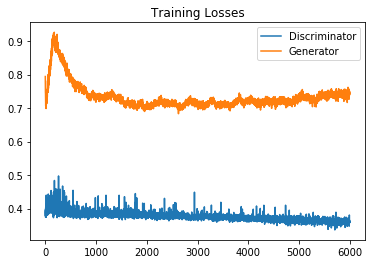

In [80]:
losses = np.array(gan.losses)

fig, ax = plt.subplots()
plt.plot([i[0][0] for i in losses], label='Discriminator')
plt.plot([i[1] for i in losses], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

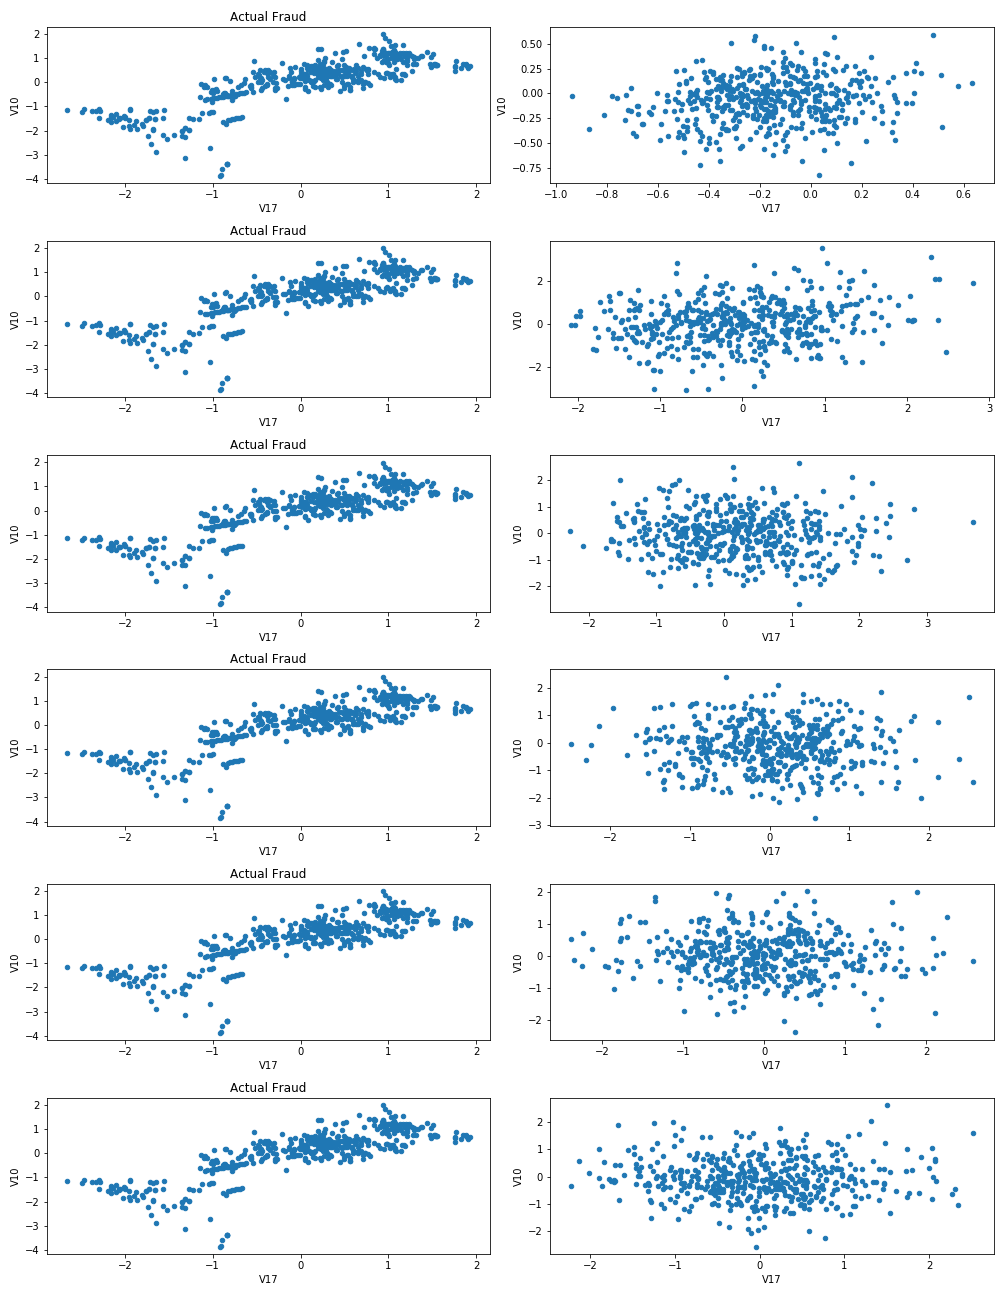

In [81]:
from IPython.display import Image
Image(filename='GANv1-ssl-v17-v10-img_2.png')

In [66]:
plt.figure()

In [15]:
plt.close()

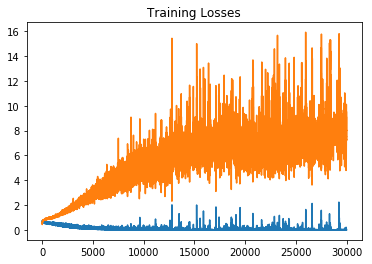

In [68]:
fig

In [50]:
test = pd.DataFrame([0,0,0,0,0,1,1,0], columns=['Class'])

In [58]:
indices = [i for i, x in enumerate(test.values) if x == 1]

In [59]:
indices

[5, 6]